In [1]:
import re 
import glob
import numpy as np
import os
import pandas as pd
import multiprocessing
import nltk
import gensim.models.word2vec as w2v
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import sklearn.manifold
import codecs

%matplotlib inline


In [2]:
book_paths= sorted(glob.glob('data/clean/*.txt'))
print('Found books : ',book_paths)

Found books :  ['data/clean/got-1.txt', 'data/clean/got-2.txt', 'data/clean/got-3.txt', 'data/clean/got-4.txt', 'data/clean/got-5.txt']


In [3]:
raw_corpus=u""   

for book_path in book_paths:
    print('Reading :', book_path)
    with codecs.open(book_path,'r',encoding='utf-8') as book_file:
        raw_corpus+= book_file.read()
    print('corpus is now {0} characters long'.format(len(raw_corpus)))
    print()
    

Reading : data/clean/got-1.txt
corpus is now 1608939 characters long

Reading : data/clean/got-2.txt
corpus is now 3377596 characters long

Reading : data/clean/got-3.txt
corpus is now 5674305 characters long

Reading : data/clean/got-4.txt
corpus is now 7386642 characters long

Reading : data/clean/got-5.txt
corpus is now 9699509 characters long



In [4]:
print(type(raw_corpus),len(raw_corpus),raw_corpus[:500])

<class 'str'> 9699509 “We should start back,” Gared urged as the woods began to grow dark around them.

“The wildlings are dead.”

“Do the dead frighten you?” Ser Waymar Royce asked with just the hint of a smile.

Gared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come and go. “Dead is dead,” he said. “We have no business with the dead.”

“Are they dead?” Royce asked softly. “What proof have we?”

“Will saw them,” Gared said. “If he says they are dead, that’s proof enough for


In [5]:
##download modules form natural language toolkit nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/carnd/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/carnd/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
#loading the pretrained punkt model to build a tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
#conerting the raw_corpus into senences
raw_sentences = tokenizer.tokenize(raw_corpus)

In [8]:
#cleaning data a bit--- removing everything that isn't a letter like hyphens and shit
for raw_sentence in raw_sentences:
    re.sub("[^a-zA-Z]", " ", raw_sentence)

In [9]:
print(raw_sentences[20:30])
print()
print(type(raw_sentences), len(raw_sentences))

['Under the wounded pride, Will could sense something else in the older man.', 'You could taste it; a nervous tension that came perilous close to fear.', 'Will shared his unease.', 'He had been four years on the Wall.', 'The first time he had been sent beyond, all the old stories had come rushing back, and his bowels had turned to water.', 'He had laughed about it afterward.', 'He was a veteran of a hundred rangings by now, and the endless dark wilderness that the southron called the haunted forest had no more terrors for him.', 'Until tonight.', 'Something was different tonight.', 'There was an edge to this darkness that made his hackles rise.']

<class 'list'> 128757


In [10]:
#splitting sentence into a list of words
def sentence_to_wordlist(raw):
    clean = re.sub('[^a-zA-Z]'," ",raw)
    words = clean.split()
    return words

In [11]:
#for each sentence in sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [12]:
#print an example
print(raw_sentences[100])
print(sentence_to_wordlist(raw_sentences[100]))

They say you don’t feel any pain toward the end.
['They', 'say', 'you', 'don', 't', 'feel', 'any', 'pain', 'toward', 'the', 'end']


In [13]:
#counting tokens
token_count = sum(len(sentence) for sentence in sentences)
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,814,876 tokens


In [14]:
multiprocessing.cpu_count()

4

In [15]:
# using gensim library to create our model using word2vec

#setting hyperparameters

#for random no. generator
seed = 1

#no. of cores in the computer...multi-core system means faster training of the model
num_cpu= multiprocessing.cpu_count()

#sg-- it defines the training algo -- 2 choices- skip grams(sg=1) and CBOW(continuous bag of words--default(sg=0))
sg=1

#dimensions of feature vectors...
num_features = 300

#minimum word count--- ignore all words with frequency less than min_count
min_freq_count = 3

#sample isthreshold for configuring which higher-frequency words are randomly downsampled;
#default 1e-3,useful range is (0, 1e-5)
downsampling = 1e-3

#context window length---maximum distance between the current and predicted word within a sentence.
context_window_size = 7


In [16]:
# initilising our model

thrones2vec = w2v.Word2Vec(
        sg=sg,
        seed=seed,
        workers=num_cpu,
        size=num_features,
        min_count=min_freq_count,
        window=context_window_size,
        sample=downsampling
        )

In [17]:
thrones2vec.build_vocab(sentences)

In [18]:
print('the length of our thrones2vec vocabulary is :{0}'.format(len(thrones2vec.vocab)))

the length of our thrones2vec vocabulary is :17153


In [19]:
#training model
thrones2vec.train(sentences)

7008168

In [20]:
if not os.path.exists('trained'):
    os.makedirs('trained')

In [21]:
##saving the model for future use
thrones2vec.save(os.path.join('trained','thrones2vec.w2v'))

In [22]:
##loading the saved model
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

# Exploring 'The Great Game'

### Plotting the multi-dimensional word-vectors into a 2-D space using Dimensionality Reduction

In [23]:
#initialsing TSNE
tsne = sklearn.manifold.TSNE(n_components= 2, random_state=0)

In [24]:
all_word_vectors_matrix = thrones2vec.syn0

In [25]:
all_word_vectors_matrix.shape
##this checks out as I set my word vectors to have 300 features/dimensions

(17153, 300)

### Training TSNE

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

## Plotting the big picture

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            for word in thrones2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
points.head(8)

,word,x,y
0,catchers,1.419970,-2.576047
1,pillow,-3.142823,-2.526928
2,Suddenly,-1.586529,-1.160931
3,letter,-1.589070,0.045886
4,grabbed,0.699795,-2.715791
5,HOBB,5.526356,-0.799311
6,escaped,2.600128,2.322375
7,zorse,-1.872263,-4.533282


In [29]:
sns.set_context("poster")

### Here's what I got !!!! 

In [30]:
from IPython.display import Image

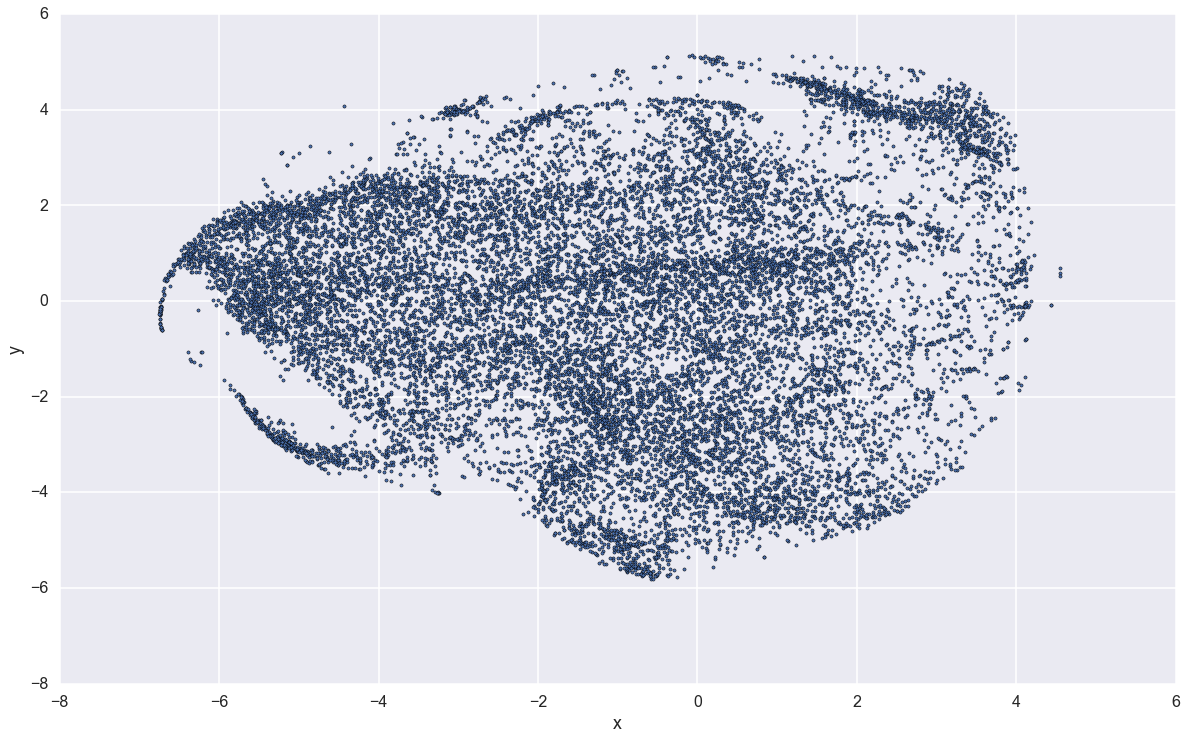

In [31]:
Image('game_of_vectors.png')

## Try your model again below

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


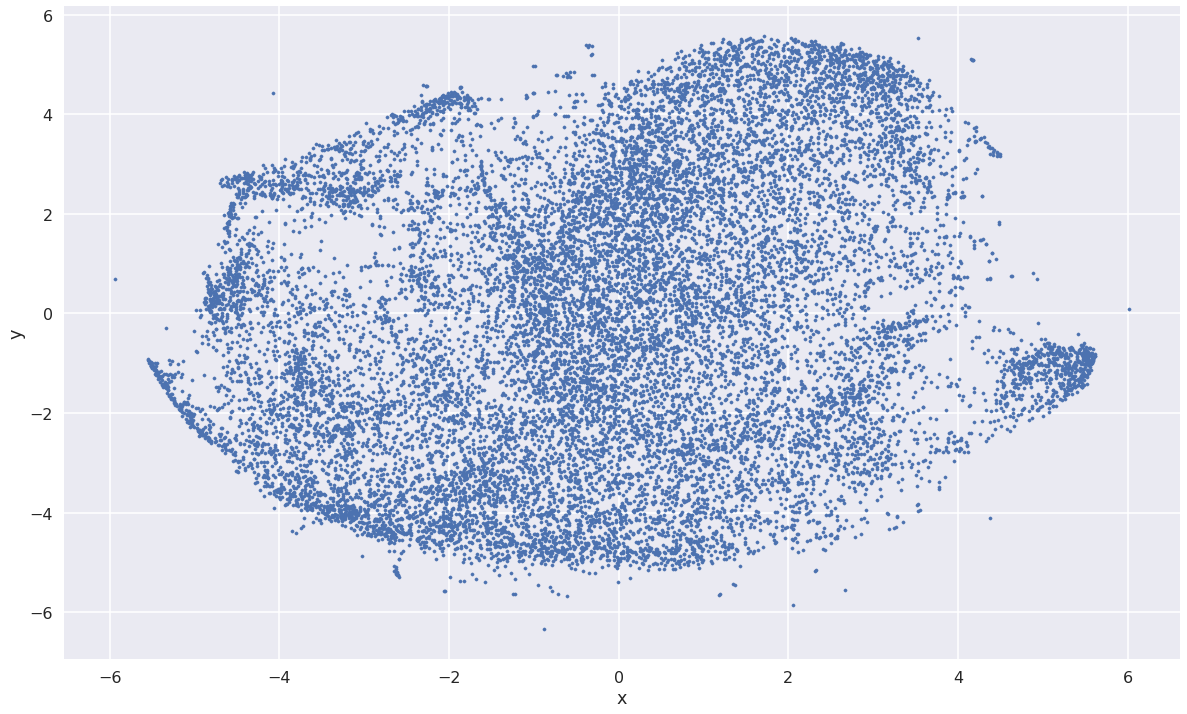

In [32]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

 ### zooming in

In [56]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1])  &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    print(type(slice), slice.shape)
#     print(slice)
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

<class 'pandas.core.frame.DataFrame'> (154, 3)


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


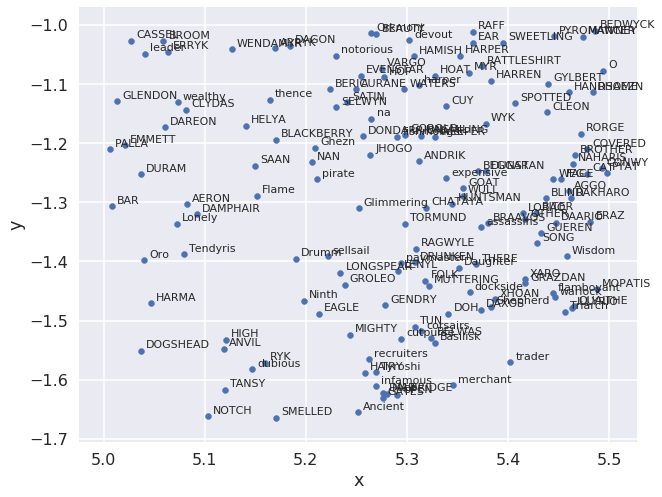

In [62]:
plot_region(x_bounds=(5.0, 5.5), y_bounds=(-1.7,-1.0))

## Exploring our model to identify underlying semantic relationships with the Game of Thrones 

In [5]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [6]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as cup is related to wine
Arya is related to Nymeria, as Dany is related to dragons


'Dany'

In [10]:
nearest_similarity_cosmul("Winter","Jon","Doom")

Winter is related to Jon, as Valyria is related to Doom


'Valyria'

In [36]:
thrones2vec.most_similar("Targaryen")

[('Conqueror', 0.8137491941452026),
 ('reign', 0.7433048486709595),
 ('Daeron', 0.7427845001220703),
 ('Jaehaerys', 0.7413517832756042),
 ('Aegon', 0.7392498254776001),
 ('conquered', 0.735207200050354),
 ('Targaryens', 0.7342640161514282),
 ('Unworthy', 0.7297759652137756),
 ('II', 0.7243639230728149),
 ('Daenerys', 0.7209944128990173)]

In [30]:
thrones2vec.most_similar("Lannister")


[('pays', 0.6583771109580994),
 ('Tywin', 0.6538059115409851),
 ('Kevan', 0.6390879154205322),
 ('debts', 0.6354672312736511),
 ('Jaime', 0.6257004141807556),
 ('Kingslayer', 0.608565628528595),
 ('Cersei', 0.5780410766601562),
 ('crimson', 0.5772358179092407),
 ('lion', 0.5638918876647949),
 ('downfall', 0.5597789287567139)]

In [32]:
thrones2vec.most_similar('Stark')

[('Eddard', 0.7230002880096436),
 ('Winterfell', 0.6671098470687866),
 ('Lyanna', 0.6512895822525024),
 ('beheaded', 0.6432904601097107),
 ('executed', 0.6407086253166199),
 ('CATELYN', 0.6374412775039673),
 ('Karstark', 0.6241185665130615),
 ('Brandon', 0.6220952272415161),
 ('Robb', 0.6216405630111694),
 ('Rickard', 0.6127247214317322)]

In [35]:
thrones2vec.most_similar('Winter')

[('Joramun', 0.7711575627326965),
 ('Fire', 0.7306472063064575),
 ('Coming', 0.7268755435943604),
 ('BRAN', 0.6996488571166992),
 ('Gorne', 0.6958225965499878),
 ('Way', 0.6939732432365417),
 ('ghosts', 0.6934593319892883),
 ('impregnable', 0.6795299649238586),
 ('trumpets', 0.6773870587348938),
 ('Builder', 0.6764745116233826)]